In [1]:
!pip install swig
!pip install gymnasium[box2d]
!pip install torch
!pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376100 sha256=a56d557266f6dfc0ce0aab81f4138e440b950e592ad4fcf2c236add6d3125cb2
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x

In [1]:
"""
	This neural network module is used to
	define our actor and critic networks in PPO.
"""

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


class FeedForwardNN(nn.Module):
	"""
		A standard in_dim-64-64-out_dim Feed Forward Neural Network.
	"""
	def __init__(self, in_dim, out_dim):
		"""
			Initialize the network and set up the layers.

			Parameters:
				in_dim - input dimensions as an int
				out_dim - output dimensions as an int

			Return:
				None
		"""
		super(FeedForwardNN, self).__init__()

		self.layer1 = nn.Linear(in_dim, 64)
		self.layer2 = nn.Linear(64, 64)
		self.layer3 = nn.Linear(64, out_dim)

	def forward(self, obs):
		"""
			Runs a forward pass on the neural network.

			Parameters:
				obs - observation to pass as input

			Return:
				output - the output of our forward pass
		"""
		# Convert observation to tensor if it's a numpy array

		activation1 = F.relu(self.layer1(obs))
		activation2 = F.relu(self.layer2(activation1))
		output = self.layer3(activation2)

		return output

In [2]:
import gymnasium as gym
import time

import numpy as np
import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions import MultivariateNormal

class PPO:
	"""
		This is the PPO class we will use as our model in main.py
	"""
	def __init__(self, policy_class, env, **hyperparameters):
		"""
			Initializes the PPO model, including hyperparameters.

			Parameters:
				policy_class - the policy class to use for our actor/critic networks.
				env - the environment to train on.
				hyperparameters - all extra arguments passed into PPO that should be hyperparameters.

			Returns:
				None
		"""
		# Set device
		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

		# Initialize hyperparameters for training with PPO
		self._init_hyperparameters(hyperparameters)

		# Extract environment information
		self.env = env
		self.obs_dim = env.observation_space.shape[0]
		self.act_dim = env.action_space.shape[0]

		 # Initialize actor and critic networks
		self.actor = policy_class(self.obs_dim, self.act_dim).to(self.device)                                                   # ALG STEP 1
		self.critic = policy_class(self.obs_dim, 1).to(self.device)

		# Initialize optimizers for actor and critic
		self.actor_optim = Adam(self.actor.parameters(), lr=self.lr)
		self.critic_optim = Adam(self.critic.parameters(), lr=self.lr)

		# Initialize the covariance matrix used to query the actor for actions
		self.cov_var = torch.full(size=(self.act_dim,), fill_value=0.5).to(self.device)
		self.cov_mat = torch.diag(self.cov_var).to(self.device)

		# This logger will help us with printing out summaries of each iteration
		self.logger = {
			'delta_t': time.time_ns(),
			't_so_far': 0,          # timesteps so far
			'i_so_far': 0,          # iterations so far
			'batch_lens': [],       # episodic lengths in batch
			'batch_rews': [],       # episodic returns in batch
			'actor_losses': [],     # losses of actor network in current iteration
		}

	def learn(self, total_timesteps):
		"""
			Train the actor and critic networks. Here is where the main PPO algorithm resides.

			Parameters:
				total_timesteps - the total number of timesteps to train for

			Return:
				None
		"""
		print(f"Learning... Running {self.max_timesteps_per_episode} timesteps per episode, ", end='')
		print(f"{self.timesteps_per_batch} timesteps per batch for a total of {total_timesteps} timesteps")
		t_so_far = 0 # Timesteps simulated so far
		i_so_far = 0 # Iterations ran so far

		rewards = []
		elapsed_times = []
		actor_losses = []
		critic_losses = []

		while t_so_far < total_timesteps:                                                                       # ALG STEP 2
			# Autobots, roll out (just kidding, we're collecting our batch simulations here)
			batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens, batch_rews = self.rollout()                     # ALG STEP 3

			# Collect the rewards for the plot
			for ep_rews in batch_rews:
				rewards.append(np.sum(ep_rews))

			# Calculate how many timesteps we collected this batch
			t_so_far += np.sum(batch_lens)

			# Increment the number of iterations
			i_so_far += 1

			# Logging timesteps so far and iterations so far
			self.logger['t_so_far'] = t_so_far
			self.logger['i_so_far'] = i_so_far

			# Calculate advantage at k-th iteration
			V, _ = self.evaluate(batch_obs, batch_acts)
			A_k = batch_rtgs - V.detach()                                                                       # ALG STEP 5

			# One of the only tricks I use that isn't in the pseudocode. Normalizing advantages
			# isn't theoretically necessary, but in practice it decreases the variance of
			# our advantages and makes convergence much more stable and faster. I added this because
			# solving some environments was too unstable without it.
			A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)

			actor_losses_it = []
			critic_losses_it = []
			# This is the loop where we update our network for some n epochs
			for _ in range(self.n_updates_per_iteration):                                                       # ALG STEP 6 & 7
				# Calculate V_phi and pi_theta(a_t | s_t)
				V, curr_log_probs = self.evaluate(batch_obs, batch_acts)

				# Calculate the ratio pi_theta(a_t | s_t) / pi_theta_k(a_t | s_t)
				# NOTE: we just subtract the logs, which is the same as
				# dividing the values and then canceling the log with e^log.
				# For why we use log probabilities instead of actual probabilities,
				# here's a great explanation:
				# https://cs.stackexchange.com/questions/70518/why-do-we-use-the-log-in-gradient-based-reinforcement-algorithms
				# TL;DR makes gradient ascent easier behind the scenes.
				ratios = torch.exp(curr_log_probs - batch_log_probs)

				# Calculate surrogate losses.
				surr1 = ratios * A_k
				surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k

				# Calculate actor and critic losses.
				# NOTE: we take the negative min of the surrogate losses because we're trying to maximize
				# the performance function, but Adam minimizes the loss. So minimizing the negative
				# performance function maximizes it.
				actor_loss = (-torch.min(surr1, surr2)).mean()
				critic_loss = nn.MSELoss()(V, batch_rtgs)
				actor_losses_it.append(actor_loss.item())
				critic_losses_it.append(critic_loss.item())

				# Calculate gradients and perform backward propagation for actor network
				self.actor_optim.zero_grad()
				actor_loss.backward(retain_graph=True)
				self.actor_optim.step()

				# Calculate gradients and perform backward propagation for critic network
				self.critic_optim.zero_grad()
				critic_loss.backward()
				self.critic_optim.step()

				# Log actor loss
				self.logger['actor_losses'].append(actor_loss.detach())

			# Print a summary of our training so far
			delta_t = self._log_summary()
	 		# Collect elapsed times
			elapsed_times.append(delta_t)
			actor_losses.append(np.mean(actor_losses_it))
			critic_losses.append(np.mean(critic_losses_it))

	 	# At the end of training, save network parameters
		torch.save(self.actor.state_dict(), './ppo_actor.pth')
		torch.save(self.critic.state_dict(), './ppo_critic.pth')
		return rewards, actor_losses, critic_losses, elapsed_times

	def rollout(self):
		"""
			Too many transformers references, I'm sorry. This is where we collect the batch of data
			from simulation. Since this is an on-policy algorithm, we'll need to collect a fresh batch
			of data each time we iterate the actor/critic networks.

			Parameters:
				None

			Return:
				batch_obs - the observations collected this batch. Shape: (number of timesteps, dimension of observation)
				batch_acts - the actions collected this batch. Shape: (number of timesteps, dimension of action)
				batch_log_probs - the log probabilities of each action taken this batch. Shape: (number of timesteps)
				batch_rtgs - the Rewards-To-Go of each timestep in this batch. Shape: (number of timesteps)
				batch_lens - the lengths of each episode this batch. Shape: (number of episodes)
		"""
		# Batch data. For more details, check function header.
		batch_obs = []
		batch_acts = []
		batch_log_probs = []
		batch_rews = []
		batch_rtgs = []
		batch_lens = []

		# Episodic data. Keeps track of rewards per episode, will get cleared
		# upon each new episode
		ep_rews = []

		t = 0 # Keeps track of how many timesteps we've run so far this batch

		# Keep simulating until we've run more than or equal to specified timesteps per batch
		while t < self.timesteps_per_batch:
			ep_rews = [] # rewards collected per episode

			# Reset the environment. sNote that obs is short for observation.
			obs = self.env.reset()[0]
			done = False

			# Run an episode for a maximum of max_timesteps_per_episode timesteps
			for ep_t in range(self.max_timesteps_per_episode):
				# If render is specified, render the environment
				if self.render and (self.logger['i_so_far'] % self.render_every_i == 0) and len(batch_lens) == 0:
					self.env.render()

				t += 1 # Increment timesteps ran this batch so far

				# Track observations in this batch
				batch_obs.append(obs)

				# Calculate action and make a step in the env.
				# Note that rew is short for reward.
				action, log_prob = self.get_action(obs)
				obs, rew, done, _, _ = self.env.step(action)

				# Track recent reward, action, and action log probability
				ep_rews.append(rew)
				batch_acts.append(action)
				batch_log_probs.append(log_prob)

				# If the environment tells us the episode is terminated, break
				if done:
					break

			# Track episodic lengths and rewards
			batch_lens.append(ep_t + 1)
			batch_rews.append(ep_rews)

		# Reshape data as tensors in the shape specified in function description, before returning
		batch_obs = torch.tensor(np.array(batch_obs), dtype=torch.float).to(self.device)
		batch_acts = torch.tensor(np.array(batch_acts), dtype=torch.float).to(self.device)
		batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float).to(self.device)
		batch_rtgs = self.compute_rtgs(batch_rews).to(self.device)                                                              # ALG STEP 4

		# Log the episodic returns and episodic lengths in this batch.
		self.logger['batch_rews'] = batch_rews
		self.logger['batch_lens'] = batch_lens

		return batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens, batch_rews

	def compute_rtgs(self, batch_rews):
		"""
			Compute the Reward-To-Go of each timestep in a batch given the rewards.

			Parameters:
				batch_rews - the rewards in a batch, Shape: (number of episodes, number of timesteps per episode)

			Return:
				batch_rtgs - the rewards to go, Shape: (number of timesteps in batch)
		"""
		# The rewards-to-go (rtg) per episode per batch to return.
		# The shape will be (num timesteps per episode)
		batch_rtgs = []

		# Iterate through each episode
		for ep_rews in reversed(batch_rews):

			discounted_reward = 0 # The discounted reward so far

			# Iterate through all rewards in the episode. We go backwards for smoother calculation of each
			# discounted return (think about why it would be harder starting from the beginning)
			for rew in reversed(ep_rews):
				discounted_reward = rew + discounted_reward * self.gamma
				# Insert at the beginning to maintain correct order
				batch_rtgs.insert(0, discounted_reward)

		# Convert the rewards-to-go into a tensor
		batch_rtgs = torch.tensor(np.array(batch_rtgs), dtype=torch.float).to(self.device)

		return batch_rtgs

	def get_action(self, obs):
		"""
			Queries an action from the actor network, should be called from rollout.

			Parameters:
				obs - the observation at the current timestep

			Return:
				action - the action to take, as a numpy array
				log_prob - the log probability of the selected action in the distribution
		"""
		# Query the actor network for a mean action
		mean = self.actor(torch.tensor(obs, dtype = torch.float).to(self.device))

		# Create a distribution with the mean action and std from the covariance matrix above.
		# For more information on how this distribution works, check out Andrew Ng's lecture on it:
		# https://www.youtube.com/watch?v=JjB58InuTqM
		dist = MultivariateNormal(mean, self.cov_mat)

		# Sample an action from the distribution
		action = dist.sample()

		# Calculate the log probability for that action
		log_prob = dist.log_prob(action)

		# Return the sampled action and the log probability of that action in our distribution
		return action.cpu().detach().numpy(), log_prob.detach()

	def evaluate(self, batch_obs, batch_acts):
		"""
			Estimate the values of each observation, and the log probs of
			each action in the most recent batch with the most recent
			iteration of the actor network. Should be called from learn.

			Parameters:
				batch_obs - the observations from the most recently collected batch as a tensor.
							Shape: (number of timesteps in batch, dimension of observation)
				batch_acts - the actions from the most recently collected batch as a tensor.
							Shape: (number of timesteps in batch, dimension of action)

			Return:
				V - the predicted values of batch_obs
				log_probs - the log probabilities of the actions taken in batch_acts given batch_obs
		"""
		# Query critic network for a value V for each batch_obs. Shape of V should be same as batch_rtgs
		V = self.critic(batch_obs).squeeze()

		# Calculate the log probabilities of batch actions using most recent actor network.
		# This segment of code is similar to that in get_action()
		mean = self.actor(batch_obs)
		dist = MultivariateNormal(mean, self.cov_mat)
		log_probs = dist.log_prob(batch_acts)

		# Return the value vector V of each observation in the batch
		# and log probabilities log_probs of each action in the batch
		return V, log_probs

	def _init_hyperparameters(self, hyperparameters):
		"""
			Initialize default and custom values for hyperparameters

			Parameters:
				hyperparameters - the extra arguments included when creating the PPO model, should only include
									hyperparameters defined below with custom values.

			Return:
				None
		"""
		# Initialize default values for hyperparameters
		# Algorithm hyperparameters
		self.timesteps_per_batch = 4800                 # Number of timesteps to run per batch
		self.max_timesteps_per_episode = 1600           # Max number of timesteps per episode
		self.n_updates_per_iteration = 5                # Number of times to update actor/critic per iteration
		self.lr = 0.005                                 # Learning rate of actor optimizer
		self.gamma = 0.95                               # Discount factor to be applied when calculating Rewards-To-Go
		self.clip = 0.2                                 # Recommended 0.2, helps define the threshold to clip the ratio during SGA

		# Miscellaneous parameters
		self.render = False                              # If we should render during rollout
		self.render_every_i = 10                        # Only render every n iterations
		self.seed = None                                # Sets the seed of our program, used for reproducibility of results

		# Change any default values to custom values for specified hyperparameters
		for param, val in hyperparameters.items():
			exec('self.' + param + ' = ' + str(val))

		# Sets the seed if specified
		if self.seed != None:
			# Check if our seed is valid first
			assert(type(self.seed) == int)

			# Set the seed
			torch.manual_seed(self.seed)
			print(f"Successfully set seed to {self.seed}")

	def _log_summary(self):
		"""
			Print to stdout what we've logged so far in the most recent batch.

			Parameters:
				None

			Return:
				None
		"""
		# Calculate logging values. I use a few python shortcuts to calculate each value
		# without explaining since it's not too important to PPO; feel free to look it over,
		# and if you have any questions you can email me (look at bottom of README)
		delta_t = self.logger['delta_t']
		self.logger['delta_t'] = time.time_ns()
		delta_t = (self.logger['delta_t'] - delta_t) / 1e9
		delta_t = str(round(delta_t, 2))

		t_so_far = self.logger['t_so_far']
		i_so_far = self.logger['i_so_far']
		avg_ep_lens = np.mean(self.logger['batch_lens'])
		avg_ep_rews = np.mean([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']])
		avg_actor_loss = np.mean([losses.cpu().float().mean() for losses in self.logger['actor_losses']])

		# Round decimal places for more aesthetic logging messages
		avg_ep_lens = str(round(avg_ep_lens, 2))
		avg_ep_rews = str(round(avg_ep_rews, 2))
		avg_actor_loss = str(round(avg_actor_loss, 5))

		# Print logging statements
		print(flush=True)
		print(f"-------------------- Iteration #{i_so_far} --------------------", flush=True)
		print(f"Average Episodic Length: {avg_ep_lens}", flush=True)
		print(f"Average Episodic Return: {avg_ep_rews}", flush=True)
		print(f"Average Loss: {avg_actor_loss}", flush=True)
		print(f"Timesteps So Far: {t_so_far}", flush=True)
		print(f"Iteration took: {delta_t} secs", flush=True)
		print(f"------------------------------------------------------", flush=True)
		print(flush=True)

		# Reset batch-specific logging data
		self.logger['batch_lens'] = []
		self.logger['batch_rews'] = []
		self.logger['actor_losses'] = []

		#returning delta_t to plot elapsed_times
		return float(delta_t)

Learning... Running 1600 timesteps per episode, 4800 timesteps per batch for a total of 10000.0 timesteps

-------------------- Iteration #1 --------------------
Average Episodic Length: 284.12
Average Episodic Return: -105.41
Average Loss: -0.00592
Timesteps So Far: 4830
Iteration took: 8.29 secs
------------------------------------------------------


-------------------- Iteration #2 --------------------
Average Episodic Length: 582.33
Average Episodic Return: -105.54
Average Loss: -0.00409
Timesteps So Far: 10071
Iteration took: 8.07 secs
------------------------------------------------------



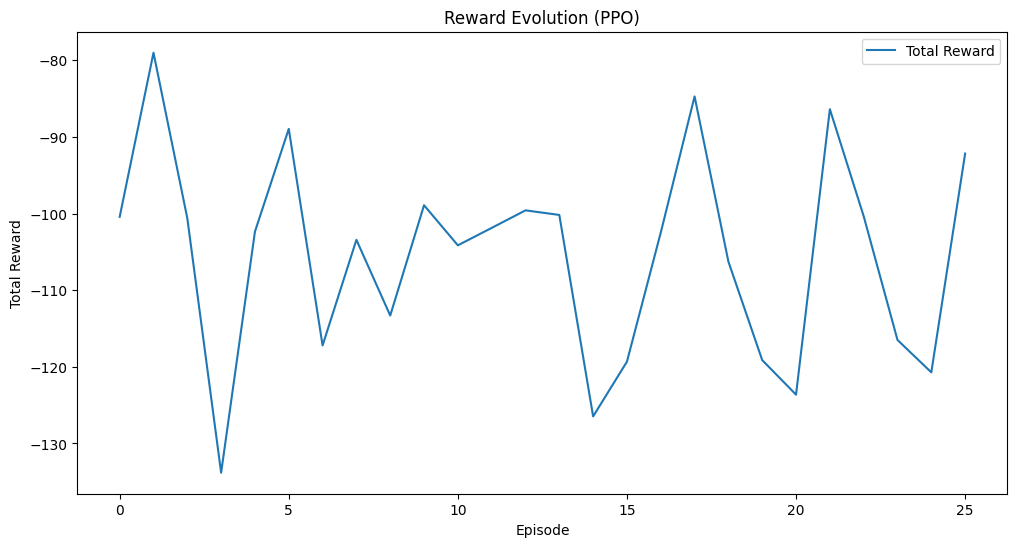

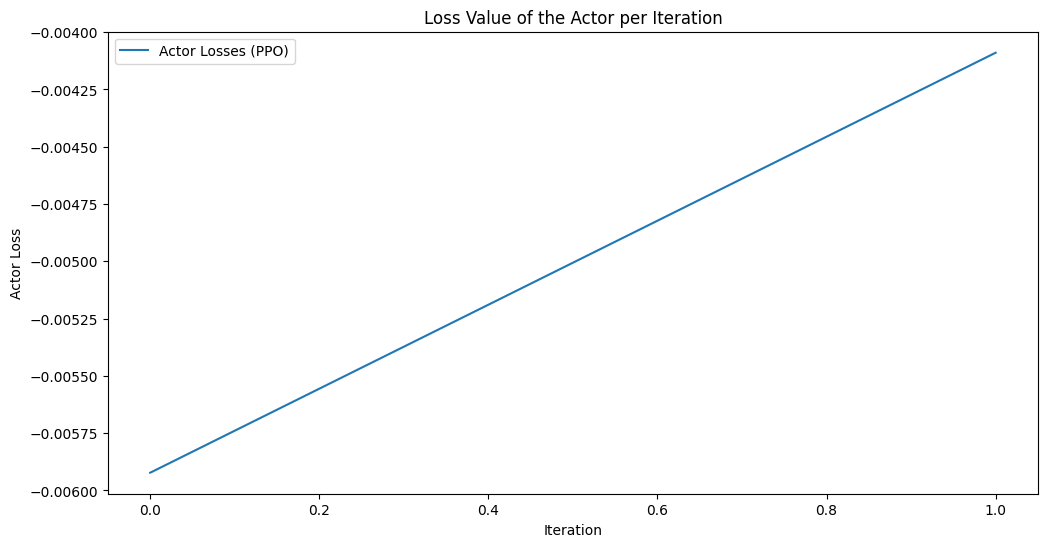

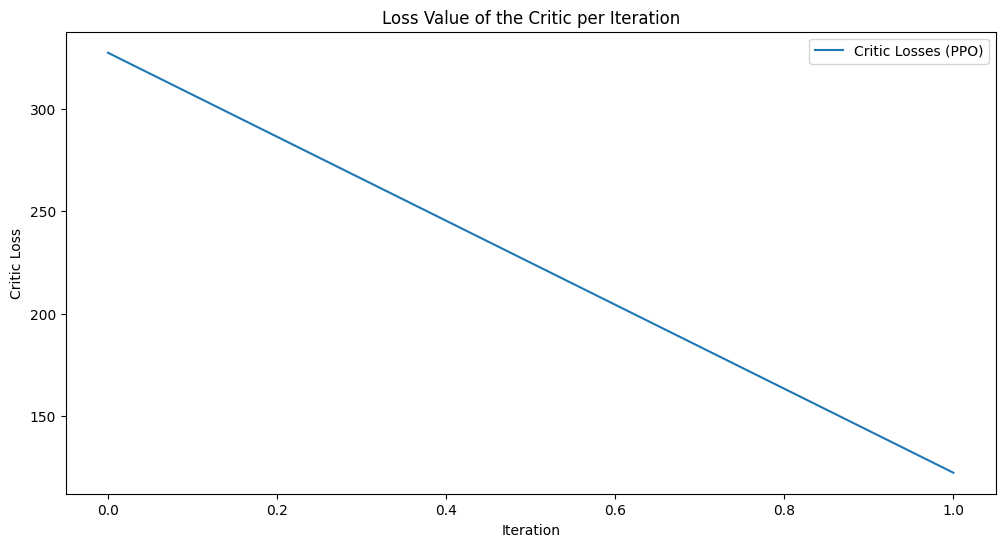

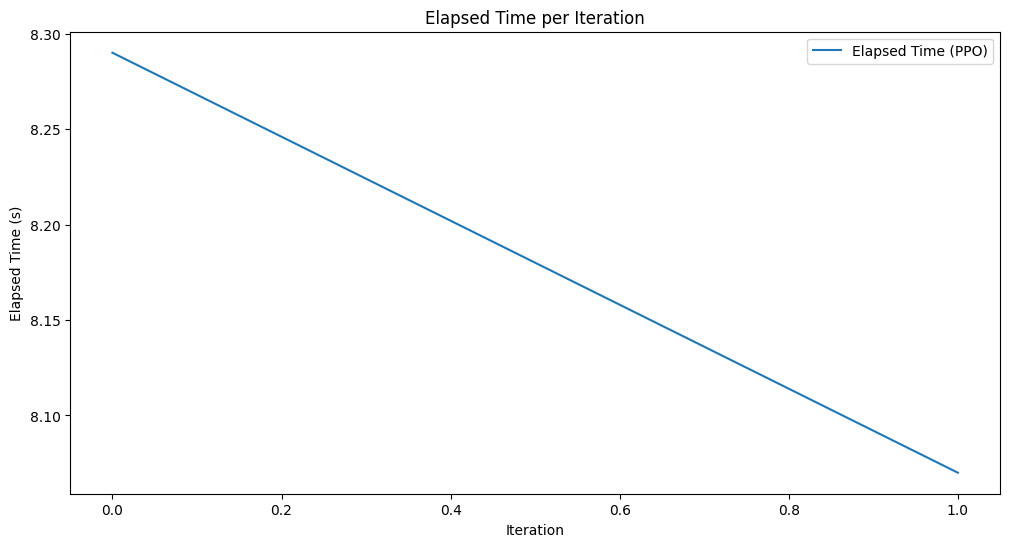

In [8]:
#train

env = gym.make("BipedalWalker-v3")

hyperparameters = {
    'lr': 1e-3,
    'gamma': 0.99,
    'n_updates_per_iteration': 10,
    'timesteps_per_batch': 6000,
    'max_timesteps_per_episode': 2000,
}

model = PPO(policy_class=FeedForwardNN, env=env, **hyperparameters)
rewards, actor_losses, critic_losses, elapsed_times = model.learn(total_timesteps=1e7)

#plotta i rewards e gli elapsed times delle iterazioni (ora no sbatti copia da altro codice)

window_size = 100
# Function to calculate the moving average using np.mean
def moving_average(data, window_size=window_size):
    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = np.mean(window)
        moving_averages.append(window_average)
    return moving_averages

plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Total Reward')
if len(rewards) >= window_size:
    plt.plot(range(window_size, len(rewards) + 1), moving_average(rewards), label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'Reward Evolution (PPO)')
plt.legend()
plt.savefig(f'Rewards Evolutions PPO.png')

# Plot actor losses
plt.figure(figsize=(12, 6))
plt.plot(actor_losses, label=f'Actor Losses (PPO)')
plt.xlabel('Iteration')
plt.ylabel('Actor Loss')
plt.title(f'Loss Value of the Actor per Iteration')
plt.legend()
plt.savefig(f'Actor Losses PPO.png')

# Plot critic losses
plt.figure(figsize=(12, 6))
plt.plot(critic_losses, label=f'Critic Losses (PPO)')
plt.xlabel('Iteration')
plt.ylabel('Critic Loss')
plt.title(f'Loss Value of the Critic per Iteration')
plt.legend()
plt.savefig(f'Critic Losses PPO.png')


# Plot elapsed times
plt.figure(figsize=(12, 6))
plt.plot(elapsed_times, label=f'Elapsed Time (PPO)')
plt.xlabel('Iteration')
plt.ylabel('Elapsed Time (s)')
plt.title(f'Elapsed Time per Iteration')
plt.legend()
plt.savefig(f'Elapsed Times PPO.png')

#print(rewards, elapsed_times)

In [9]:
#test

"""
    This file is used only to evaluate our trained policy/actor after
    training in main.py with ppo.py. I wrote this file to demonstrate
    that our trained policy exists independently of our learning algorithm,
    which resides in ppo.py. Thus, we can test our trained policy without
    relying on ppo.py.
"""

def _log_summary(ep_len, ep_ret, ep_num):
    """
        Print to stdout what we've logged so far in the most recent episode.

        Parameters:
            None

        Return:
            None
    """
    # Round decimal places for more aesthetic logging messages
    ep_len = str(round(ep_len, 2))
    ep_ret = str(round(ep_ret, 2))

    # Print logging statements
    print(flush=True)
    print(f"-------------------- Episode #{ep_num} --------------------", flush=True)
    print(f"Episodic Length: {ep_len}", flush=True)
    print(f"Episodic Return: {ep_ret}", flush=True)
    print(f"------------------------------------------------------", flush=True)
    print(flush=True)


def eval_policy(policy, env, episodes, device, render=False):
    rewards = []
    lengths = []
    """
        Evaluate a trained policy on a given environment.
        Parameters:
            policy - The trained policy to test, basically another name for our actor model
            env - The environment to test the policy on
            episodes - The number of episodes to run
            render - Whether we should render our episodes. False by default.

        Return:
            rewards, episodic lengths
        
    """
    # Rollout with the policy and environment, and log each episode's data
    for ep_num in range(1, episodes + 1):
        obs = env.reset()[0]
        done = False
        render_freq = 10

        # number of timesteps so far
        t = 0

        # Logging data
        ep_len = 0            # episodic length
        ep_ret = 0            # episodic return

        while not done:
            t += 1

            # Render environment if specified, off by default
            if render and t % render_freq == 0:
                env.render()

            # Query deterministic action from policy and run it
            with torch.no_grad():
                action = policy(torch.tensor(obs, dtype=torch.float).to(device)).cpu().detach().numpy()
            obs, rew, done, _, _ = env.step(action)

            # Sum all episodic rewards as we go along
            ep_ret += rew

        # Track episodic length
        ep_len = t
        _log_summary(ep_len=ep_len, ep_ret=ep_ret, ep_num=ep_num)
        rewards.append(ep_ret)
        lengths.append(ep_len)

    return rewards, lengths



-------------------- Episode #1 --------------------
Episodic Length: 128
Episodic Return: -93.71
------------------------------------------------------


-------------------- Episode #2 --------------------
Episodic Length: 132
Episodic Return: -93.66
------------------------------------------------------



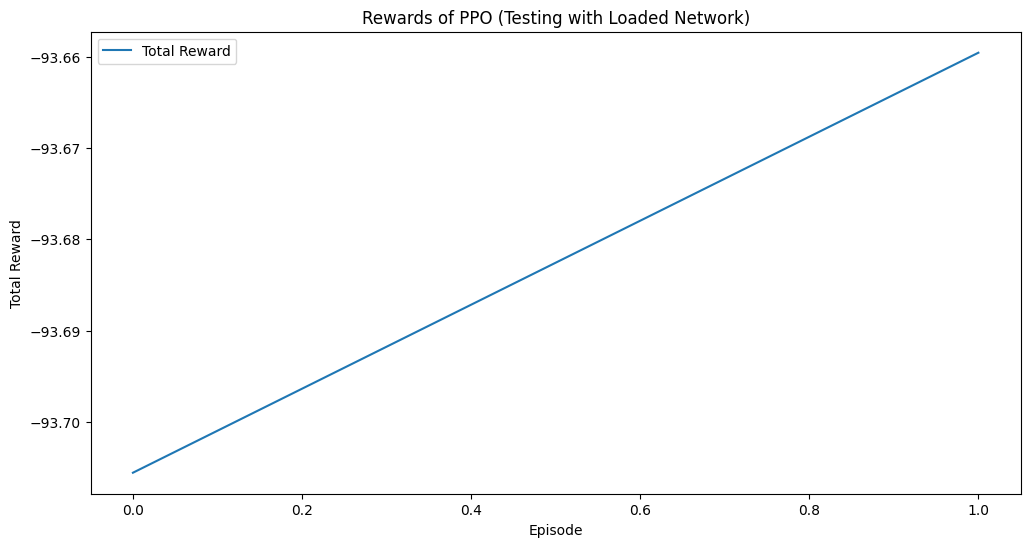

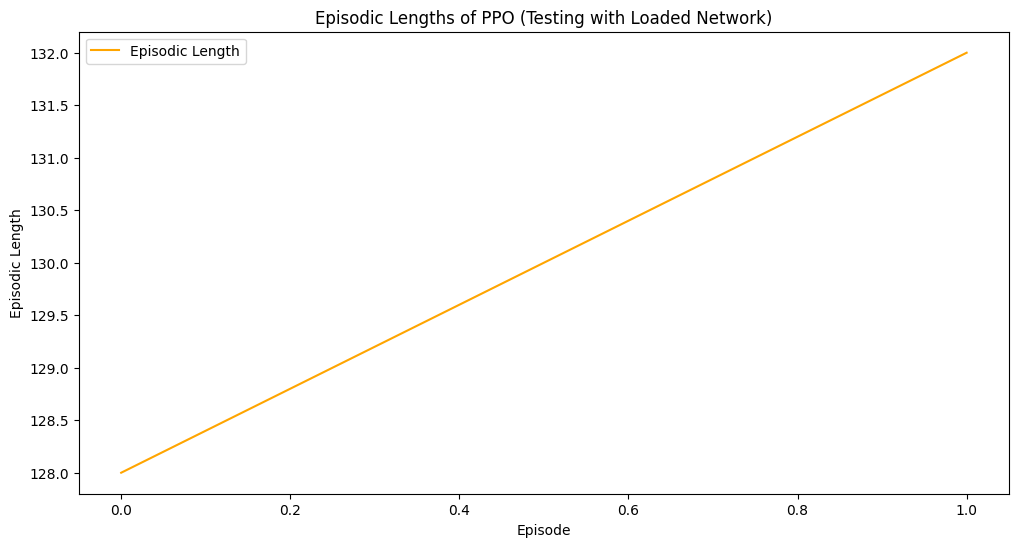

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("BipedalWalker-v3", render_mode='human')
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
actor_model = torch.load("ppo_actor.pth", map_location=device)

# Build our policy the same way we build our actor model in PPO
policy = FeedForwardNN(obs_dim, act_dim).to(device)
# Load in the actor model saved by the PPO algorithm
policy.load_state_dict(actor_model)
policy.eval()

episodes = 100

# Evaluate our policy with a separate module, eval_policy, to demonstrate
# that once we are done training the model/policy with ppo.py, we no longer need
# ppo.py since it only contains the training algorithm. The model/policy itself exists
# independently as a binary file that can be loaded in with torch.
rewards, lengths = eval_policy(policy=policy, env=env, episodes=episodes, device=device, render=False)

plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'Rewards of PPO (Testing with Loaded Network)')
plt.legend()
plt.savefig(f'Rewards PPO.png')

plt.figure(figsize=(12, 6))
plt.plot(lengths, label='Episodic Length', color='orange')
plt.xlabel('Episode')
plt.ylabel('Episodic Length')
plt.title(f'Episodic Lengths of PPO (Testing with Loaded Network)')
plt.legend()
plt.savefig(f'Episodic Lengths PPO.png')
